In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from tqdm import tqdm_notebook
import collections
tqdm_notebook().pandas()
from utils import *
from utils_clust import *
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None
from sklearn.metrics.pairwise import pairwise_distances
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

A Jupyter Widget

In [18]:
import utils_clust
import importlib
utils = importlib.reload(utils_clust)
from utils_clust import *

In [3]:
train_df = pd.read_csv('prep_train.csv')


train_df.transaction_date = train_df.transaction_date.progress_apply(lambda x: parse(x))

train_df["week_day"] = train_df.transaction_date.apply(lambda x: x.weekday())



/Users/antonzaharenkov/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


A Jupyter Widget

In [4]:
train_df = ter_using_upd(train_df)

In [5]:
train_df.shape, train_df[train_df.count_ters>1].shape

((1125751, 22), (955118, 22))

In [6]:
train_df[train_df.count_ters>2].customer_id.nunique()

9826

In [7]:
train_df1 = train_df[train_df.count_ters>2]

# Пытаюсь вручную кластеризовать дома

In [30]:
cust_ids = train_df.groupby('customer_id').home_add_lat.size().index[30:40]

In [25]:
cust_id

Index(['0001f322716470bf9bfc1708f06f00fc', '0007297d86e14bd68bd87b1dbdefe302',
       '000b709c6c6fb1e8efcfd95e57c2a9de', '0027a7618d97cc9fbda55fac457eaeb7',
       '002b9f6e118c54f1292e03d1a04d516e', '0031915eb230f772681fb5dc5a8d1c31',
       '003360bff9882ca4a4f93394dd984822', '0037f3de3d890df1022cc760a1dfd9d6',
       '003fa58414cc55531fcc38423bea8f8e', '0046c2952fb808aa11f74abce5abe097'],
      dtype='object', name='customer_id')

In [9]:
cust_id ='ff7e1c6c07469b28a07847540385e767'

transactions:  7
dbscan ready
Number of clusters: 1


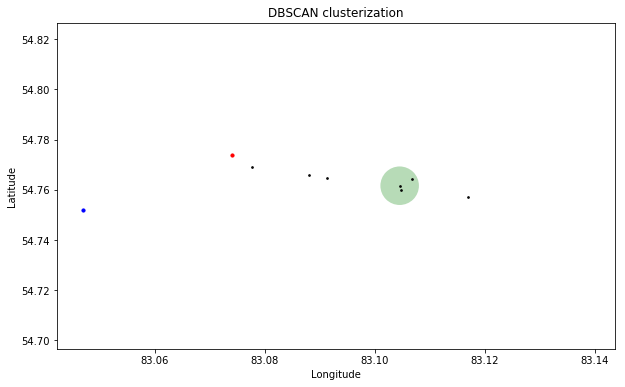

transactions:  12
dbscan ready
Number of clusters: 4


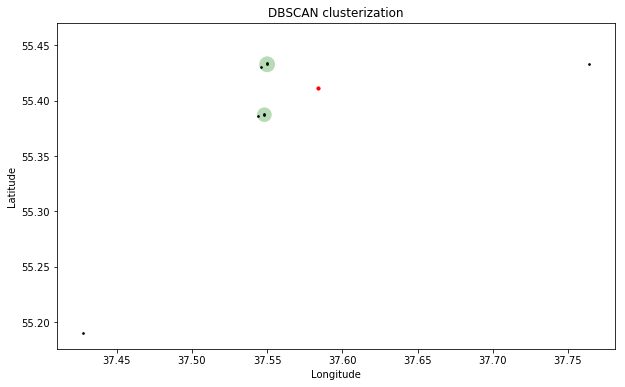

transactions:  52
dbscan ready
Number of clusters: 24


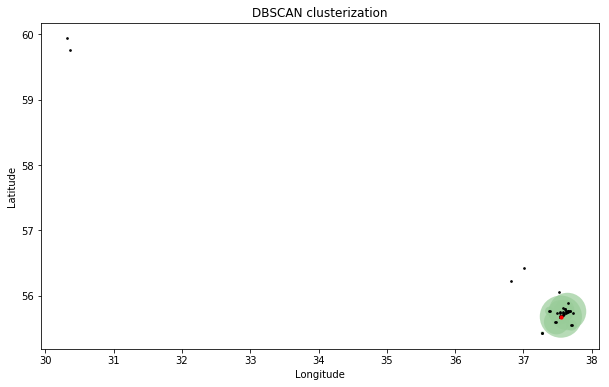

transactions:  40
dbscan ready
Number of clusters: 5


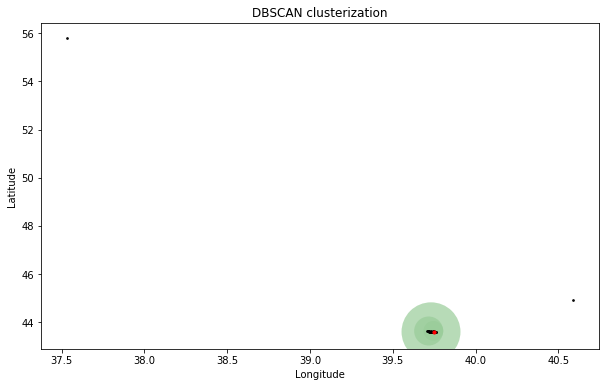

transactions:  3
dbscan ready
Number of clusters: 2


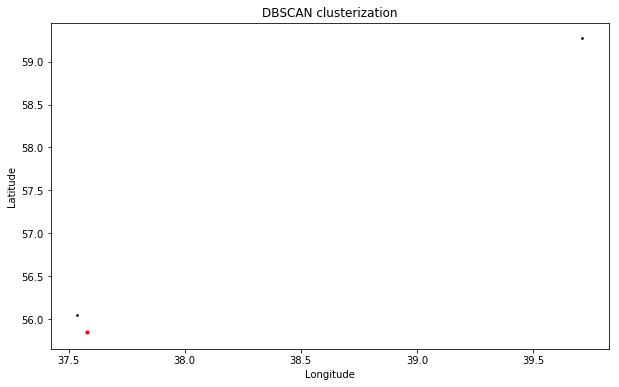

transactions:  20
dbscan ready
Number of clusters: 7


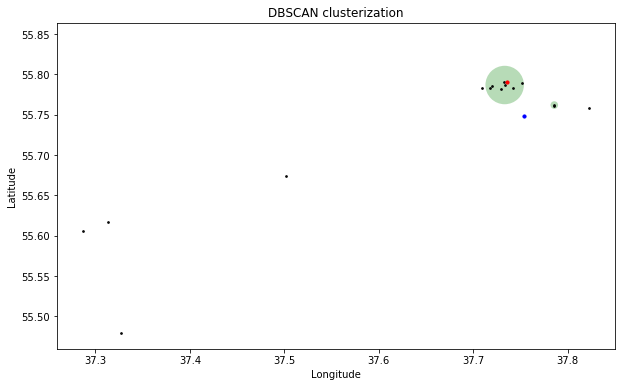

transactions:  108
dbscan ready
Number of clusters: 19


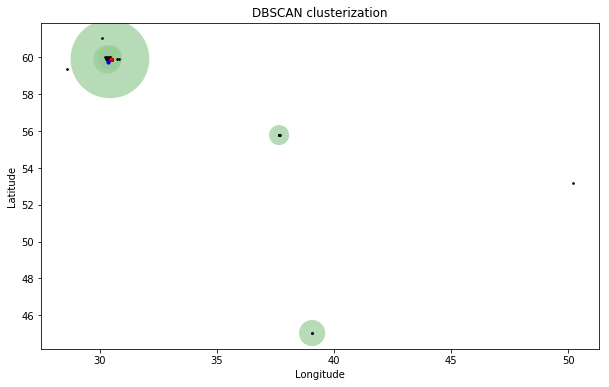

transactions:  16
dbscan ready
Number of clusters: 5


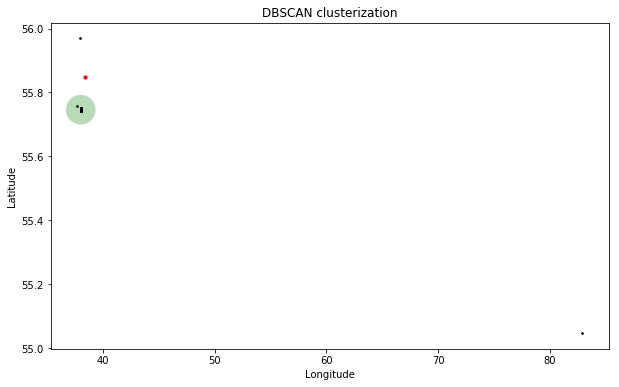

transactions:  79
dbscan ready
Number of clusters: 12


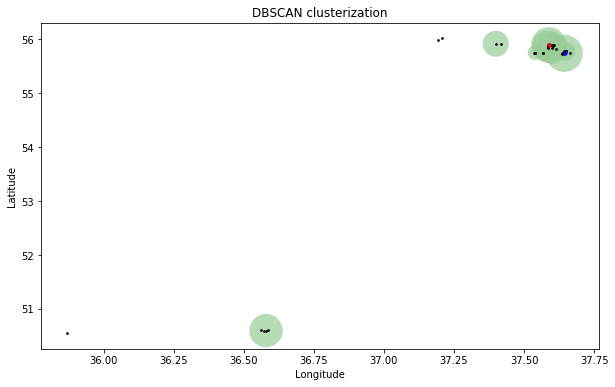

transactions:  16
dbscan ready
Number of clusters: 3


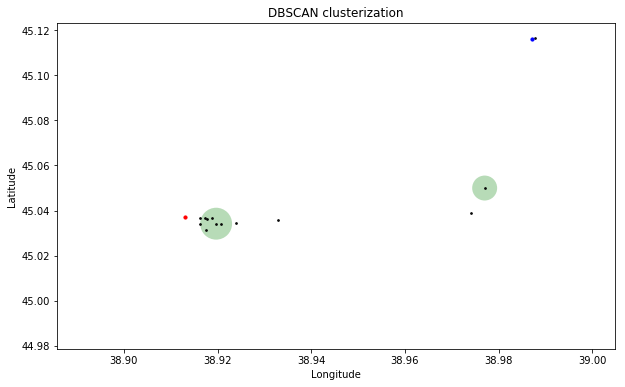

In [31]:
for cust_id in cust_ids:
    df = train_df[train_df.customer_id == cust_id]
    df = df[~df.pos_address_lat.isnull()][['pos_address_lat', 'pos_address_lon', 'count_ters']].drop_duplicates().rename({'pos_address_lat': 'lat', 'pos_address_lon': 'lon'}, axis=1)

    coords = df.as_matrix(columns=['lat', 'lon'])
    weights = df.as_matrix(columns=['count_ters'])
    print('transactions: ', len(coords))
    kms_per_radian = 6371.0088
    epsilon = 1.5 / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords), sample_weight=weights)
    print('dbscan ready')
    df['l'] = db.labels_
    df = df[df.l != -1]
    coords = df.as_matrix(columns=['lat', 'lon'])
    cluster_labels = df.l.values
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    clusters1 = clusters[clusters.apply(lambda x: len(x)>1)]
    #clusters = clusters[mask]
    df = pd.DataFrame()
    df['lat'], df['lon'] = np.array([i for j in clusters.values for i in j])[:,0], np.array([i for j in clusters.values for i in j])[:,1]

    centermost_points = clusters.map(get_centermost_point)
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

    cluster_sizes = clusters.map(get_cluster_size)
    fig, ax = plt.subplots(figsize=[10, 6])
    rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=cluster_sizes)
    df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
    home_scatter = ax.scatter(train_df[train_df.customer_id == cust_id].home_add_lon.median(), train_df[train_df.customer_id == cust_id].home_add_lat.median(), c='r', s=10)
    work_scatter = ax.scatter(train_df[train_df.customer_id == cust_id].work_add_lon.median(), train_df[train_df.customer_id == cust_id].work_add_lat.median(), c='blue', s=10)
    ax.set_title('DBSCAN clusterization')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
    plt.show()